**Further train DeepCell Models with K's Data and Make Predictions**<br>
Starting from model trained with tn nuclear data, further train the model with K's data resized and cut into 25*7 512x512 patches. There are a total of 12,574 training instances.<br>
200 epochs, semanticdatagenerator, resized<br>
mAP 0.

In [24]:
starting_model_path = 'tn1.0_nuclear_20221102.h5' # the model trained with nucleus data from the Tissuenet V1.0 dataset
INPUT_PATH="images/training_resized_512x512/"
model_name = 'tn1.0_nuclear_K_512x512resized' 
model_path = '{}.h5'.format(model_name)
epochs=200 # 20 sec per step 

In [25]:
import syotil

import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
from timeit import default_timer
import os
from skimage import img_as_ubyte

import deepcell
from deepcell import image_generators
from deepcell.utils.train_utils import rate_scheduler, get_callbacks, count_gpus
from deepcell_toolbox.utils import resize, tile_image, untile_image
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE

print(tf.__version__)
print(deepcell.__version__)

2.7.1
0.11.1


In [26]:
import glob
FILENAMES = glob.glob(INPUT_PATH+"*_img.png")
print(len(FILENAMES))
print(FILENAMES)

175
['images/training_resized_512x512/M872956_JML_Position8_CD8_train21_img.png', 'images/training_resized_512x512/M872956_JML_Position10_CD3_train13_img.png', 'images/training_resized_512x512/M872956_JML_Position9_CD3_train20_img.png', 'images/training_resized_512x512/M872956_JML_Position8_CD8_train6_img.png', 'images/training_resized_512x512/M926910_CFL_Position7_CD3_train24_img.png', 'images/training_resized_512x512/M926910_CFL_Position7_CD3_train4_img.png', 'images/training_resized_512x512/M872956_JML_Position8_CD3_train1_img.png', 'images/training_resized_512x512/M872956_JML_Position10_CD3_train21_img.png', 'images/training_resized_512x512/M872956_JML_Position8_CD8_train17_img.png', 'images/training_resized_512x512/M872956_JML_Position9_CD3_train15_img.png', 'images/training_resized_512x512/M872956_JML_Position10_CD3_train7_img.png', 'images/training_resized_512x512/M926910_CFL_Position7_CD3_train5_img.png', 'images/training_resized_512x512/M872956_JML_Position10_CD3_train1_img.pn

In [27]:
imgs = [io.imread(CURR_IM_NAME) for CURR_IM_NAME in FILENAMES]
X_train = tf.stack(imgs)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

masks = [io.imread(CURR_IM_NAME.replace("img","masks")) for CURR_IM_NAME in FILENAMES]
y_train = tf.stack(masks)
y_train = np.expand_dims(y_train, axis=-1)
print(y_train.shape)

(175, 512, 512, 1)
(175, 512, 512, 1)


In [29]:
np.max(masks) # sanity check

2688

In [43]:
# create dataloader
seed=0
min_objects = 10

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}

# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.CroppingDataGenerator()

batch_size = 4 # 8 causes memory outage

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = None
# datagen_val.flow(
#     {'X': X_val, 'y': y_val},
#     seed=seed,
#     transforms=transforms,
#     transforms_kwargs=transforms_kwargs,
#     min_objects=min_objects,
#     batch_size=batch_size)

# get number of training and validation instances

cnts_train = [np.max(y_train[i,...]) for i in range(y_train.shape[0])]
print(np.sum(cnts_train)) # total number of training instances

306615


In [116]:
mask_cnt=[len(np.unique(x)) for x in masks]
print(np.sort(mask_cnt))
indices = [mask_cnt.index(1)]
indices.extend([i for i, x in enumerate(mask_cnt) if x == 10])
indices.extend([i for i, x in enumerate(mask_cnt) if x == 28])
indices.extend([i for i, x in enumerate(mask_cnt) if x == 41])
indices.extend([i for i, x in enumerate(mask_cnt) if x == 44])
indices.extend([i for i, x in enumerate(mask_cnt) if x == 52])
indices.extend([i for i, x in enumerate(mask_cnt) if x == 58])
print(indices)

[   1   10   10   10   28   41   44   52   58   72   76   80   82   89
  101  107  107  113  116  128  160  163  167  179  192  223  224  224
  248  256  261  265  270  275  279  280  287  287  292  301  305  313
  325  328  331  364  371  377  390  441  464  478  514  574  575  580
  582  591  611  634  647  653  653  655  667  669  675  678  682  682
  721  727  728  732  749  751  761  783  793  798  799  821  842  842
  849  850  859  860  866  885  902  903  928  940  965  977  993  995
  997 1003 1008 1014 1026 1035 1037 1038 1040 1056 1069 1081 1083 1083
 1087 1123 1129 1129 1135 1135 1142 1149 1149 1167 1175 1178 1191 1209
 1218 1222 1254 1281 1288 1307 1311 1312 1330 1369 1379 1385 1439 1446
 1450 1475 1481 1486 1492 1493 1517 1536 1537 1540 1548 1561 1567 1574
 1588 1661 1662 1677 1704 1707 1719 1789 1796 1797 1807 1818 1840 1851
 1863 1991 1995 2036 2063 2113 2136]
[143, 42, 120, 151, 128, 67, 136, 63, 18]


In [105]:
[FILENAMES[x] for x in indices]

['images/training_resized_512x512/M872956_JML_Position8_CD8_train14_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD8_train9_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD3_train14_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD8_train4_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD4_train4_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD8_train3_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD4_train9_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD4_train14_img.png',
 'images/training_resized_512x512/M872956_JML_Position8_CD3_train9_img.png']

images/training_resized_512x512/M872956_JML_Position8_CD3_train9_img.png


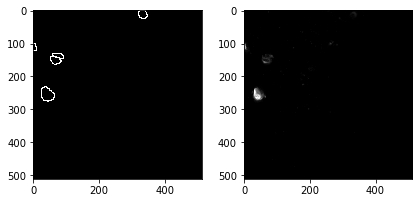

[   0   46   57   74  104  138  140  173  184  187  224  231  298  313
  322  324  325  327  404  414  417  421  519  522  552  561  598  599
  601  605  607  608  672  690  693  699  702  730  737  739  740  742
  743  746  748  749  750  866  896  924  939  970 1120 1195 1252 1356
 1565 1670]
[   0   46   57   74  104  138  140  173  184  187  224  231  298  313
  322  324  325  327  404  414  417  421  519  522  552  561  598  599
  601  605  607  608  672  690  693  699  702  730  737  739  740  742
  743  746  748  749  750  896  924  939  970 1120 1195 1252 1356 1565
 1670]


In [127]:
i=18
print(FILENAMES[i])
tmp=syotil.masks_to_outlines(io.imread(FILENAMES[i].replace("_img","_masks")))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
io.imshow(tmp)
plt.subplot(1, 2, 2) # row 1, col 2 index 1
io.imshow(io.imread(FILENAMES[i]))
plt.show()
print(np.unique(masks[i]))
print(np.unique(masks[i][10:500,10:500]))

In [129]:
np.histogram(masks[i], bins=np.append(np.unique(masks[i]), np.inf))

[   0.   46.   57.   74.  104.  138.  140.  173.  184.  187.  224.  231.
  298.  313.  322.  324.  325.  327.  404.  414.  417.  421.  519.  522.
  552.  561.  598.  599.  601.  605.  607.  608.  672.  690.  693.  699.
  702.  730.  737.  739.  740.  742.  743.  746.  748.  749.  750.  866.
  896.  924.  939.  970. 1120. 1195. 1252. 1356. 1565. 1670.   inf]


(array([258432,     20,      8,     26,     14,     16,     24,     15,
            42,     42,     52,     23,     80,     30,      6,      1,
             3,     10,      6,      8,     44,     12,      7,     22,
            42,     42,     12,      1,      3,      1,      3,     20,
            26,      6,     24,      3,     10,     12,    300,      8,
            12,      3,      4,     18,      3,    520,     11,      5,
            80,    170,     16,     44,     22,   1220,     52,     24,
            12,    472]),
 array([   0.,   46.,   57.,   74.,  104.,  138.,  140.,  173.,  184.,
         187.,  224.,  231.,  298.,  313.,  322.,  324.,  325.,  327.,
         404.,  414.,  417.,  421.,  519.,  522.,  552.,  561.,  598.,
         599.,  601.,  605.,  607.,  608.,  672.,  690.,  693.,  699.,
         702.,  730.,  737.,  739.,  740.,  742.,  743.,  746.,  748.,
         749.,  750.,  866.,  896.,  924.,  939.,  970., 1120., 1195.,
        1252., 1356., 1565., 1670.,   inf]))

In [106]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(np.unique(masks[18]))
#print(masks[143])
# from collections import Counter
# Counter(masks[143]).keys()
import scipy
max_votes = scipy.stats.mode(masks[143])
max_votes

[   0   46   57   74  104  138  140  173  184  187  224  231  298  313
  322  324  325  327  404  414  417  421  519  522  552  561  598  599
  601  605  607  608  672  690  693  699  702  730  737  739  740  742
  743  746  748  749  750  866  896  924  939  970 1120 1195 1252 1356
 1565 1670]


ModeResult(mode=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


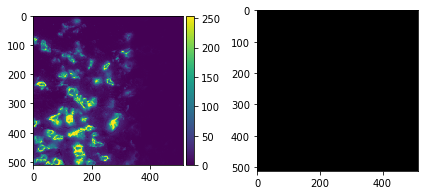

In [16]:
i=5
plt.subplot(1, 2, 1) # row 1, col 2 index 1
io.imshow(X_train[i,:,:,0])
plt.subplot(1, 2, 2) # row 1, col 2 index 1
io.imshow(y_train[i,:,:,0])
plt.show()

In [18]:
np.max(y_train[i,:,:,0])

0

**The two cells below define and train the model.** They can be skipped if a trained model will be loaded.

In [ ]:
semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=(512,512,1),
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Create a dictionary of losses for each semantic head

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

model.load_weights(starting_model_path, by_name=True)

[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)]

In [ ]:
train_data.y.shape[0] // batch_size

In [ ]:
# fit the model
print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
#     monitor="val_loss",
    # monitor='loss', # training loss
    verbose=1)          
            
loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size, # 
    epochs=epochs, 
#     validation_data=val_data,
#     validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

model.save_weights(model_path)

**Make prediction on K's data.**<br>
Using NuclearSegmentation allows setting image_mpp, which has a substantial influence on performance.

In [ ]:
prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape= (512,512,1)
)

prediction_model.load_weights(model_path, by_name=True)

In [ ]:
from deepcell.applications import NuclearSegmentation
app = NuclearSegmentation(prediction_model)
[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), app.model.layers)]

In [ ]:
import os
print(os.getcwd())
INPUT_PATH="images/test/"
FILENAMES = [f for f in os.listdir("images/training/testimages")]
print(FILENAMES)

In [23]:
# more detailed mapping of image_mpp parameter
AP_mat=[]
for CURR_IM_NAME in FILENAMES:
    print(CURR_IM_NAME)
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    AP_arr=[]
    for mpp in np.linspace(start=0.65, stop=1.6, num=4):
        print(mpp)
        prd = app._untile_output(app.predict(y, image_mpp=mpp), tile_info)[0,:,:,0]
        a=syotil.csi(mask_true, prd)
        AP_arr.append(a)
    AP_mat.append(AP_arr)
#AP_mat
[x.index(np.max(x)) for x in AP_mat]

images/training_resized_512x512/M872956_JML_Position8_CD8_train21_img.png


FileNotFoundError: No such file: '/home/yfong/deeplearning/dense_cell_segmentation/images/training_resized_512x512/images/training_resized_512x512/M872956_JML_Position8_CD8_train21_img.png'

In [ ]:
mpp_select=1

APs={}
for CURR_IM_NAME in FILENAMES:
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    print(x.shape)
    print(y.shape)
    print(tile_info)
    pred = app.predict(y, image_mpp=mpp_select)
    prd = app._untile_output(pred, tile_info)
    #io.imshow(prd[0,:,:,0])
    plt.show()
    
    APs[CURR_IM_NAME] = syotil.csi(mask_true, prd[0,:,:,0])# masks may lose one pixel if dimension is odd pixels

APs["mAP"]=np.mean(list(APs.values()))
print(APs)


In [ ]:
import pandas as pd
df = pd.DataFrame([FILENAMES+["mAP"], list(APs.values())])
print(df.transpose())
df.to_csv('images/training/csi_'+model_name+'.txt', index=False, header=False)

**mAP**<br>
image_mpp default: .<br>
image_mpp=1: .37<br>
image_mpp=2: .<br>